# Lesson 6 // Bag-of-words models

In a bag-of-words model, a text document is represented by the set of words used in the document. This is a simplified representation that ignores much of the more subtle structure of text, like the order that words appear in and grammar. Frequency counts of the words used in a document can be used to cluster documents or as features in predictive modelling.

For example, say we have a collection of newspaper articles drawn from entertainment and business categories. The set of documents is known as the *corpus*. The set of all unique words used in any of the articles consitutes our bag-of-words, also called the *vocabulary*. We can represent this data as a matrix, in which each article is a row, each word is a column, and the entry in row *i* and column *j* contains the number of times word *j* appears in document *i* (many of these values will be zero, so we have a sparse matrix). A final column contains our response variable, indicating the type of article (entertainment or business). We could use the word frequencies as features to build a model that, on the basis of frequencies of different words, predicts whether an article is about business or entertainment. This is a typical kind of use for a bag-of-words model. Some hypothetical data is shown below.

|document | sing | money | the | happy | dividend |... | response
|---------|-----|-----|-----|-------|-----|----------
|1 | 5 | 0 | 15 | 0 | 0 | ... | ent
|2 | 0 | 5 | 12 | 2 | 0 |... | bus
|3 | 0 | 0 | 3 | 0 | 6 | ... | bus
|... | ... | ... | ... | ... | ... | ... | ...
|100 | 10 | 0 | 13 | 10 | 2 | ... | ent

This notebook covers bag-of-words models. In the notebook we:

1. Show how to extract bag-of-words features from a text document.
2. Build a classification tree with bag-of-words to predict whether a Trump tweet was made before or after he became president, on the basis of the content of that tweet.
3. Show how to test that model using in- and out-of-sample validation.
4. Introduce *tf-idf* (term frequency-inverse-document-frequency), a way of weighting word frequencies that adjusts for how common a word is across documents (and hence how "special" a word is to a particular document).
5. Build another classification tree, based on tf-idf weighted bag-of-words features, and see whether we get more accurate predictions.

[Chapter 3](http://tidytextmining.com/tfidf.html) of TMR covers tf-idf and related topics.

We'll start by loading the packages we need, loading the data containing the tweets, and doing some wrangling. Most of this is the same as before - we
* parse the date the tweet was created, 
* make a new variable indicating whether the tweet was made while president, 
* do some cleaning of the tweets to remove links, retweets. Note that this time we do **not** remove stop words as we handle these via the downweighting performed by tf-idf. The relevant line of code has been commented out below - you can remove the comment and hence remove stop words (there is nothing "wrong" with doing this) and see what happens.
* turn the data into tidy text data by tokenization by word (plus some stuff important to tweets, like hashtags). 

This is mostly the same as what we did in previous notebooks, so refer back to them if anything is not clear.

In addition, we take a sample of 1000 tweets before and after he became president. That will be enough to build a model later - you can always use more data if you want.

In [1]:
library(tidyverse)
library(stringr)
library(lubridate)
library(tidytext)
library(rpart) 

options(repr.plot.width=4, repr.plot.height=3) # set plot size in the notebook

load("data/trump-tweets.RData")

# make data a tibble
tweets <- as.tibble(tweets)

# parse the date and add some date related variables
tweets <- tweets %>% 
  mutate(date = parse_datetime(str_sub(tweets$created_at,5,30), "%b %d %H:%M:%S %z %Y")) %>% 
  mutate(is_prez = (date > ymd(20161108))) %>%
  mutate(month = make_date(year(date), month(date)))

# take a random sample of 1000 tweets before and after became president
set.seed(98) #100
tweets <- tweets %>% group_by(is_prez) %>% sample_n(1000)

# turn into tidy text 
replace_reg <- "(https?:.*?([\\s]|[a-zA-Z0-9]$))|(www:.*?([\\s]|[a-zA-Z0-9]$))|&amp;|&lt;|&gt;|RT"
unnest_reg <- "[^A-Za-z_\\d#@']"
tidy_tweets <- tweets %>% 
    filter(!str_detect(text, "^RT")) %>% # remove retweets
    mutate(text = str_replace_all(text, replace_reg, "")) %>% # remove stuff we don't want like links
    unnest_tokens(word, text, token = "regex", pattern = unnest_reg) %>% # tokenize
    # filter(!word %in% stop_words$word, str_detect(word, "[a-z]")) %>% # WE LEAVE THE STOP WORDS IN THIS TIME
    filter(!str_detect(word, "@realdonaldtrump")) %>% # remove @realdonald trump, which we know is highly predictive
    select(date,word,is_prez,favorite_count,id_str,month) # choose the variables we need

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



Let's look at the most popular words:

In [2]:
tidy_tweets

date,word,is_prez,favorite_count,id_str,month
2012-10-31 03:56:31,watch,FALSE,23,263489601975504896,2012-10-01
2012-10-31 03:56:31,me,FALSE,23,263489601975504896,2012-10-01
2012-10-31 03:56:31,tonight,FALSE,23,263489601975504896,2012-10-01
2012-10-31 03:56:31,on,FALSE,23,263489601975504896,2012-10-01
2012-10-31 03:56:31,late,FALSE,23,263489601975504896,2012-10-01
2012-10-31 03:56:31,night,FALSE,23,263489601975504896,2012-10-01
2012-10-31 03:56:31,with,FALSE,23,263489601975504896,2012-10-01
2012-10-31 03:56:31,jimmy,FALSE,23,263489601975504896,2012-10-01
2012-10-31 03:56:31,fallon,FALSE,23,263489601975504896,2012-10-01
2012-10-31 03:56:31,photo,FALSE,23,263489601975504896,2012-10-01


In [3]:
tidy_tweets %>%
  group_by(word) %>%
  count() %>%
  ungroup() %>% 
  arrange(desc(n)) %>%
  filter(rank(desc(n)) <= 10)

word,n
the,1378
to,901
and,605
a,569
of,550
in,542
is,497
i,403
for,384
on,344


## Extracting bag-of-words data from text

We now put our data into "bag-of-words" form, by 

* finding all unique words used in 2000 tweets,
* counting how many times each of these words was used in each tweet.

Here we simplify things by looking only at the frequency of the 200 most popular words. We first find out what the 200 most commonly used words are. We're doing this a slightly different way to the previous block of code, where we first sorted (by the count variable `n`, using `arrange`), and then filtered by rank. Here we use the `top_n()` , a convenience function that selects the top or bottom entries in each group, ordered by `wt`.   

In [4]:
word_bag <- tidy_tweets %>%
  group_by(word) %>%
  count() %>%
  ungroup() %>%
  top_n(200, wt = n) %>%
  select(-n)

We actually end up with more than 200 words, because the 200 in `top_n()` refers to the rank of the last observation that gets included. All words tied for the last rank (200) get included, and we end up with more than 200 words. That's really not a problem here - because the main goal of the subsetting is just to reduce the full problem to something more manageable in the notebook, we don't really care if we have exactly 200 words to use as features.

In [5]:
nrow(word_bag)

[1] 201

Now we calculate the number of times each of these words was used in each of the 2000 tweets. Note that because we're using a subset of words, we might find that some tweets don't contain *any* of these words in them. These observations are dropped from the analysis. 

In [6]:
tweets_tdf <- tidy_tweets %>%
  inner_join(word_bag) %>%
  group_by(id_str,word) %>%
  count() %>%  
  group_by(id_str) %>%
  mutate(total = sum(n)) %>%
  ungroup()

Joining, by = "word"


In [7]:
tweets_tdf

id_str,word,n,total
107091854092279808,and,1,10
107091854092279808,did,1,10
107091854092279808,his,1,10
107091854092279808,love,1,10
107091854092279808,on,1,10
107091854092279808,the,1,10
107091854092279808,they,1,10
107091854092279808,to,2,10
107091854092279808,why,1,10
108920528286400512,and,1,5


We now reshape the dataset to get it into traditional format for predictive modelling, using `spread()`. This means that each tweet will be in its own row, and each word in its own column. Note that we're moving here from a tidy to untidy format, because that is the format required by **rpart** the classification tree package we're going to use to do further modelling.

In [8]:
bag_of_words <- tweets_tdf %>% 
  select(id_str,word,n) %>% 
  spread(key = word, value = n, fill = 0) %>%
  left_join(tweets %>% select(id_str,is_prez)) %>%
  select(id_str, is_prez, everything())

# number of tweets
nrow(bag_of_words)
# number of variables (words, plus id and response)
ncol(bag_of_words)

Joining, by = "id_str"


[1] 1851

[1] 203

Losing some tweets is actually a bit of a problem. There are two reasons we want the same number of tweets in both "before" and "after" classes of the response. First, many predictive modelling approaches do better with balanced data. Second, it gives us an easy benchmark (50%) to evaluate our results against. So we should check whether the dropped tweets have come disproportionately from one response class. Or equivalently, if the classes are still baalnced.

In [9]:
table(bag_of_words$is_prez)


FALSE  TRUE 
  974   877 

The classes are close to an even split, so we probably don't need to worry too much but, to be precise, we will drop the excess observations from the larger class at random.

In [10]:
min_class_size <- min(table(bag_of_words$is_prez))
bag_of_words <- bag_of_words %>% group_by(is_prez) %>% sample_n(min_class_size) %>% ungroup()
table(bag_of_words$is_prez)


FALSE  TRUE 
  877   877 

## Building a bag-of-words classifier 

Now we'd like to know whether we can use these word frequencies to predict whether a Trump tweet was made while he was president or not. We have a binary response, and continuous (integer) predictors, so we can use a variety of approaches to model this problem. Here we'll use a binary classification tree constructed using the CART algorithm, implemented in the **rpart** package. 

Before building the tree, we split our data into training and test sets. I've included 70% of the data in the training set and left the rest for testing.

In [11]:
set.seed(321)
training_ids <- bag_of_words %>% 
  group_by(is_prez) %>% 
  sample_frac(0.7) %>% 
  ungroup() %>%
  select(id_str)

training_tweets <- bag_of_words %>% 
  right_join(training_ids, by = "id_str") %>%
  select(-id_str)

test_tweets <- bag_of_words %>% 
  anti_join(training_ids, by = "id_str") %>%
  select(-id_str)

We then fit a tree to the training data.

In [12]:
fit <- rpart(factor(is_prez) ~ ., training_tweets)

And plot the full tree.

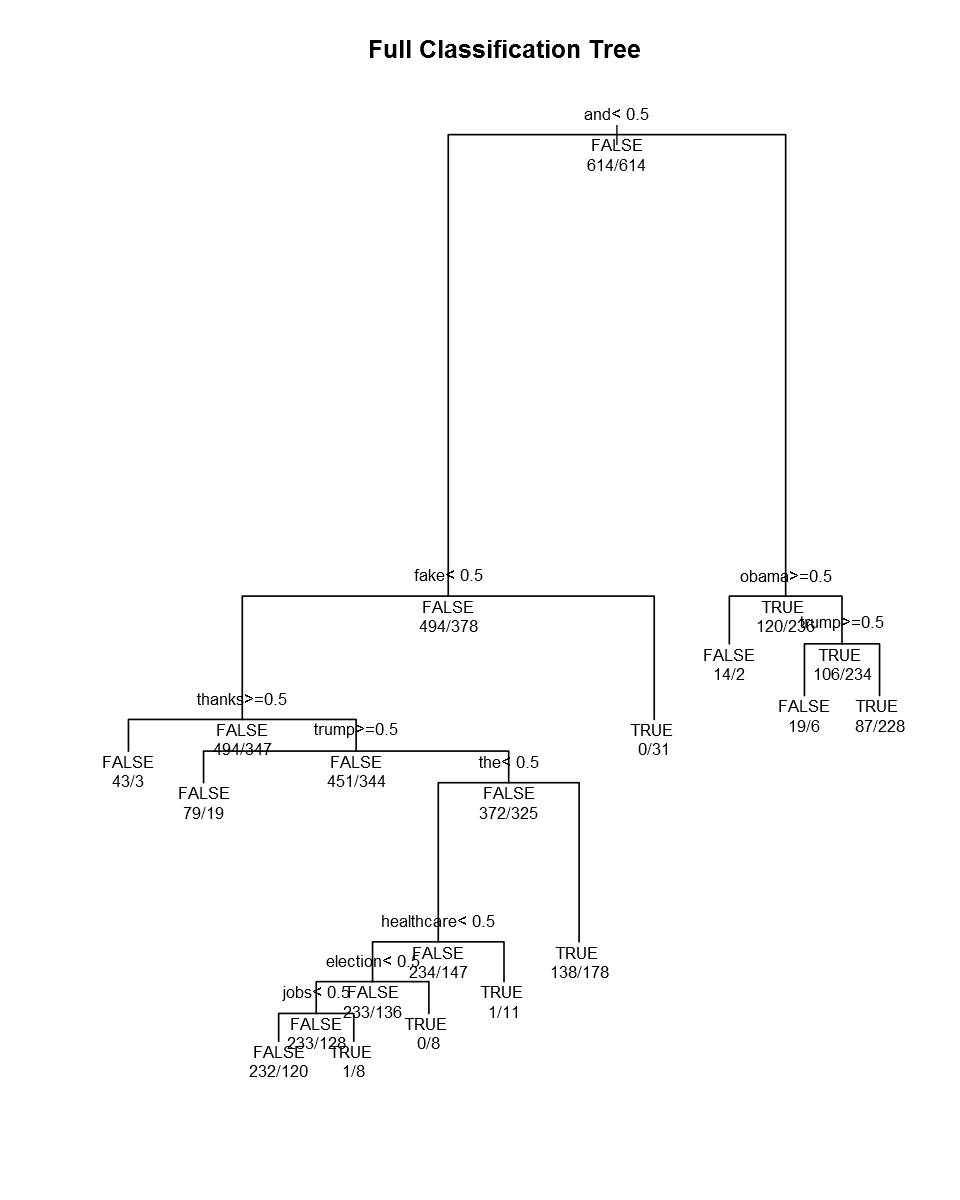

In [13]:
options(repr.plot.width=8, repr.plot.height=10)
plot(fit, main="Full Classification Tree")
text(fit, use.n=TRUE, all=TRUE, cex=.8)

We can assess the accuracy in training dataset by extracting a cross-table of predicted against observed classifications, and calculating the percentage of classification the model got correct. Because we have balanced class sizes (the same number of tweets before and after presidency)

In [14]:
fittedtrain <- predict(fit,type="class")
predtrain <- table(training_tweets$is_prez,fittedtrain)
predtrain
sum(diag(predtrain))/sum(predtrain) # training accuracy

       fittedtrain
        FALSE TRUE
  FALSE   387  227
  TRUE    150  464

[1] 0.6929967

We can do the same in the test dataset - this is the accuracy we would be most interested in.

In [15]:
fittedtest <- predict(fit,newdata=test_tweets,type="class")
predtest <- table(test_tweets$is_prez,fittedtest)
predtest
sum(diag(predtest))/sum(predtest) # test accuracy

       fittedtest
        FALSE TRUE
  FALSE   150  113
  TRUE     71  192

[1] 0.6501901

## Term frequency-inverse-document-frequency (tf-idf)

In the previous section we used the words contained in tweets, and specifically the frequencies of those words, to discriminate between a tweet made by Donald Trump was made while he was president or not. This is standard practice in text mining: we describe a document by the words that are contained in the document. 

How do we decide what words are "important" to a document - by which we mean distinguish that document from another? One approach is to use word frequency. If a word like "apple" appears frequently in a document, it is more likely to be about a recipe or health than about politics, for example. However some words that appear frequently are *not* particularly useful: words like "the", "a", and so on. These are words that may appear frequently in a particular document, but are not interesting to us *because they also appear frequently in many other documents*.

We've previously encountered these as **stop words**, and we've typically removed them from the analysis to reveal more interesting underlying patterns. Another approach is, rather than removing the stop words, is to **downweight** them. This is what tf-idf (term frequency-inverse document frequency) does. Here "term" is just used as a general indicator of the unit of text we are interested in, like "token". Tf-idf is composed of two parts: 

* The **tf** part: A term's frequency increases with how many times it is used *in that document*. For tf-idf we use *relative* frequencies: the number of times a word appears, divided by the total number of words in that document.
* The **idf**: A term’s inverse document frequency is a measure of how many documents (in the corpus) contain that term. It decreases the weight for commonly used words (which all or most documents will use) relative to words that are not used by many documents in a corpus.

Specifically, we are going to replace the term frequencies we were using before with new values called "inverse document frequency weighted term frequencies" or tf-idf for short. So each term in each document will get its own tf-idf "score", which we denote $tfidf(\text{term t in document i})$.

Then:

$$tfidf(\text{term t in document i}) = tf(\text{term t in document i}) \times idf(\text{term t})$$

where

$$tf(\text{term t in document i}) = \displaystyle\frac{\text{Number of times term t appears in document i}}{\text{Number of terms in document i}}$$  

and 

$$idf(\text{term t}) = \ln\biggl(\displaystyle\frac{\text{Number of documents in corpus}}{\text{Number of documents containing term t}}\biggr)$$ 

The log function increases in its argument, and the number of documents in the corpus is fixed, so as the number of documents containing a term increases (the denominator above), the idf part decreases. The log transform ensures that this decrease is steep initally, and then levels off. Below I show how the idf weight changes with the number of documents (out of a total of 100 documents) that have a term.

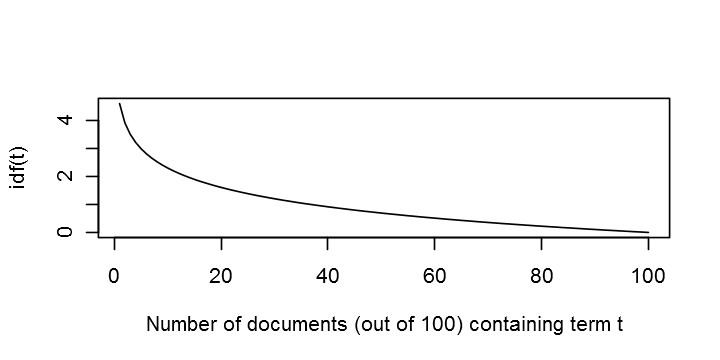

In [16]:
options(repr.plot.width=6, repr.plot.height=3) # set plot size in the notebook
plot(1:100, log(100/1:100), type = "l", 
     xlab = "Number of documents (out of 100) containing term t", ylab = "idf(t)")

As a bonus, we no longer have to carry around stop word dictionaries around with us - using idf allows us to include all words and let idf downweight the ones that are most common.

Below we carry out the calculations above to work out tf-idf values for the words (terms) in our tweets (documents).

In [17]:
ndocs <- length(unique(tweets_tdf$id_str))

idf <- tweets_tdf %>% 
  group_by(word) %>% 
  summarize(docs_with_word = n()) %>% 
  ungroup() %>%
  mutate(idf = log(ndocs / docs_with_word)) %>% arrange(desc(idf))

tweets_tdf <- tweets_tdf %>% 
    left_join(idf, by = "word") %>% 
    mutate(tf = n/total, tf_idf = tf * idf)

Let's explore how the weighting affects the terms that come up as "most important", by looking at one particular tweet.

In [18]:
set.seed(987)
random_tweet <- sample(tweets_tdf$id_str,1)
tweets %>% filter(id_str == random_tweet) %>% select(text)

Adding missing grouping variables: `is_prez`


is_prez,text
TRUE,The meeting with the @nytimes is back on at 12:30 today. Look forward to it!


Below we rank words in descending order of importance by the criterion of word frequency (`n`). By changing this to inverse document frequency (`idf`) and tf-idf (`tf_idf`) you can see which words become more or less important, and get a sense for why.

In [19]:
tweets_tdf %>% filter(id_str == random_tweet) %>% arrange(desc(n))

id_str,word,n,total,docs_with_word,idf,tf,tf_idf
801087976889520128,the,2,12,921,0.6980213,0.16666667,0.1163369
801087976889520128,at,1,12,189,2.2817343,0.08333333,0.1901445
801087976889520128,back,1,12,51,3.5916557,0.08333333,0.2993046
801087976889520128,forward,1,12,30,4.1222839,0.08333333,0.3435237
801087976889520128,is,1,12,434,1.4504368,0.08333333,0.1208697
801087976889520128,it,1,12,237,2.0554212,0.08333333,0.1712851
801087976889520128,look,1,12,33,4.0269738,0.08333333,0.3355811
801087976889520128,on,1,12,318,1.7614299,0.08333333,0.1467858
801087976889520128,to,1,12,730,0.9304368,0.08333333,0.0775364
801087976889520128,today,1,12,78,3.1667725,0.08333333,0.2638977


We've done the tf-idf calculation "from scratch" to better understanding of what is happening. The **tidytext** package has a function `bind_tf_idf()` that does the same thing.

In [20]:
tweets_tdf <- tweets_tdf %>% 
    select(-idf, -tf, -tf_idf) %>% # remove the old ones we worked out
  bind_tf_idf(word, id_str, n) # replace with values from tidytext

tweets_tdf %>% filter(id_str == random_tweet) %>% arrange(desc(n)) # check same as above

id_str,word,n,total,docs_with_word,tf,idf,tf_idf
801087976889520128,the,2,12,921,0.16666667,0.6980213,0.1163369
801087976889520128,at,1,12,189,0.08333333,2.2817343,0.1901445
801087976889520128,back,1,12,51,0.08333333,3.5916557,0.2993046
801087976889520128,forward,1,12,30,0.08333333,4.1222839,0.3435237
801087976889520128,is,1,12,434,0.08333333,1.4504368,0.1208697
801087976889520128,it,1,12,237,0.08333333,2.0554212,0.1712851
801087976889520128,look,1,12,33,0.08333333,4.0269738,0.3355811
801087976889520128,on,1,12,318,0.08333333,1.7614299,0.1467858
801087976889520128,to,1,12,730,0.08333333,0.9304368,0.0775364
801087976889520128,today,1,12,78,0.08333333,3.1667725,0.2638977


# Redoing the classification tree, this time with tf-idf features 

Tf-idf features often give better accuracy in predictive modelling than using word frequencies. In this section we repeat the earlier analysis, building a classification tree to predict whether a tweet was made before or after becoming president, but replacing the word frequency features with the tf-idf values calculated above. 

We start by reshaping the dataset:

In [21]:
bag_of_words <- tweets_tdf %>% 
  select(id_str, word, tf_idf) %>%  # note the change, using tf-idf
  spread(key = word, value = tf_idf, fill = 0) %>%  
  left_join(tweets %>% select(id_str,is_prez))

Joining, by = "id_str"


We use same training and test sets as before.

In [22]:
training_tweets <- bag_of_words %>% 
  right_join(training_ids, by = "id_str") %>%
  select(-id_str)

test_tweets <- bag_of_words %>% 
  anti_join(training_ids, by = "id_str") %>%
  select(-id_str)

We fit a tree to training data:

In [23]:
fit <- rpart(factor(is_prez) ~ ., training_tweets)

Plot the tree we just created:

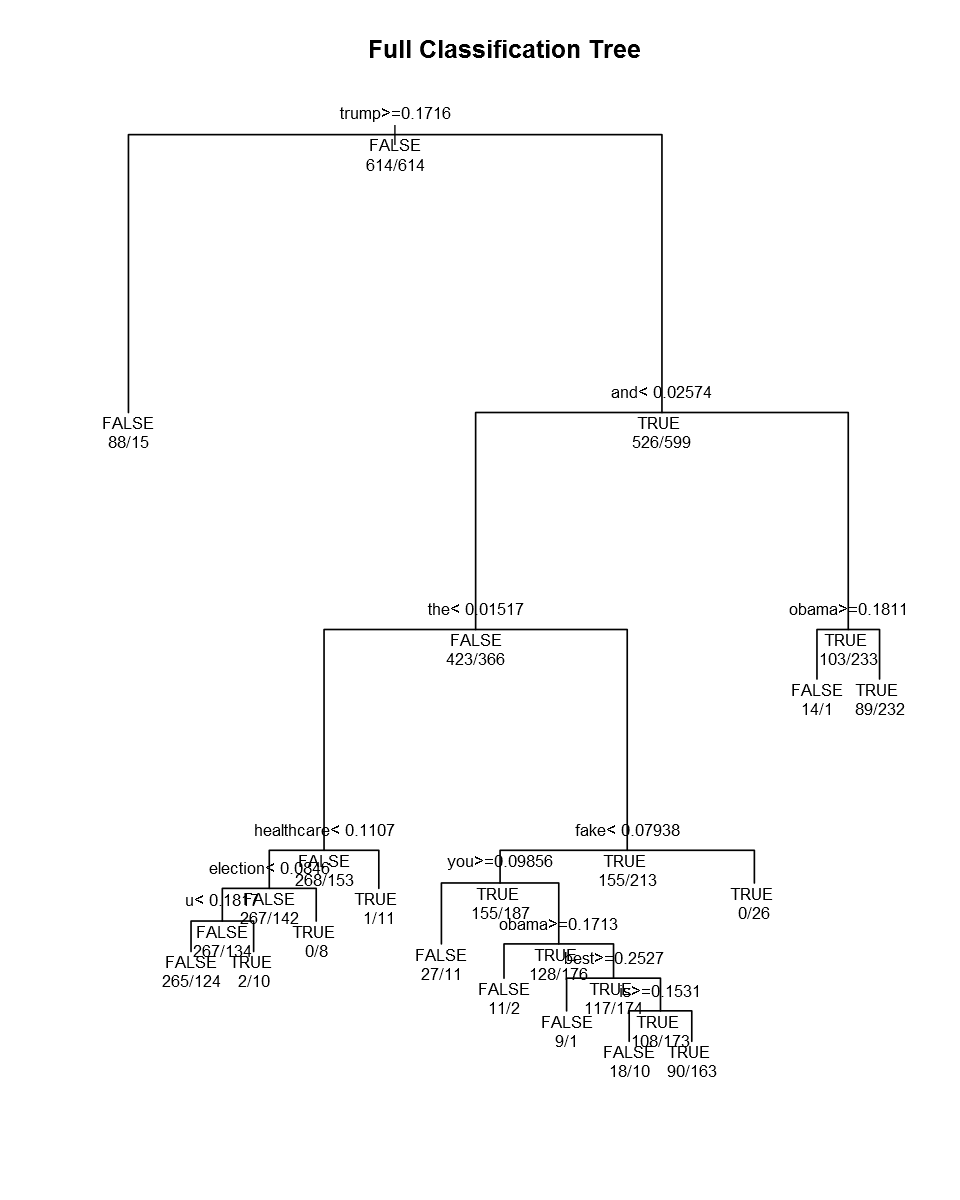

In [24]:
options(repr.plot.width=8, repr.plot.height=10)
plot(fit, main="Full Classification Tree")
text(fit, use.n=TRUE, all=TRUE, cex=.8)

And check the accuracy in training and test datasets:

In [25]:
fittedtrain <- predict(fit,type="class")
predtrain <- table(training_tweets$is_prez,fittedtrain)
predtrain
sum(diag(predtrain))/sum(predtrain) # training accuracy

       fittedtrain
        FALSE TRUE
  FALSE   432  182
  TRUE    164  450

[1] 0.718241

In [26]:
fittedtest <- predict(fit,newdata=test_tweets,type="class")
predtest <- table(test_tweets$is_prez,fittedtest)
predtest
sum(diag(predtest))/sum(predtest) # test accuracy

       fittedtest
        FALSE TRUE
  FALSE   234  126
  TRUE     87  176

[1] 0.6581059

We get a very slight improvement in accuracy from replacing word frequency features with ones based on tf-idf.

## Exercises

1. Try and improve on the classification models described above. Try the following (for example):
    + use bigrams rather than words as tokens.
    + include other explanatory variables included in the `tweets` data frame.
    + remove stopwords.
    + use more than 200 words in the bag-of-words.
    